In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from utils.metrics import show_clustering_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils.metrics import compute_wcss, compute_dunn_index, show_clustering_report ,silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Load Dataset

In [4]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')

# Keep lon/lat for visualization only
lon_lat = dataset[['lon', 'lat']].copy()

# Remove lon/lat and fire from clustering
dataset.drop(columns=['lon', 'lat', 'fire'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.copy()
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

print("=== X shape:", X.shape)
print("=== X columns:", X.columns)

=== Dataset Types :
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  f

In [5]:
print(f"Nombre de features avant PCA : {X.shape[1]}")
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)
print(f"Nombre de features après PCA : {X_pca.shape[1]}")

Nombre de features avant PCA : 40
Nombre de features après PCA : 12


# Elbow Method + silhoutte Analysis ==> finding the optimal K 

Testing K values from 2 to 50...


c:\Users\anfel\anaconda3\envs\dm\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


K=10: Inertia=492634.46, Silhouette=0.3589
K=20: Inertia=347615.43, Silhouette=0.2888
K=30: Inertia=270165.83, Silhouette=0.2791
K=40: Inertia=229694.02, Silhouette=0.2867
K=50: Inertia=204240.58, Silhouette=0.2799


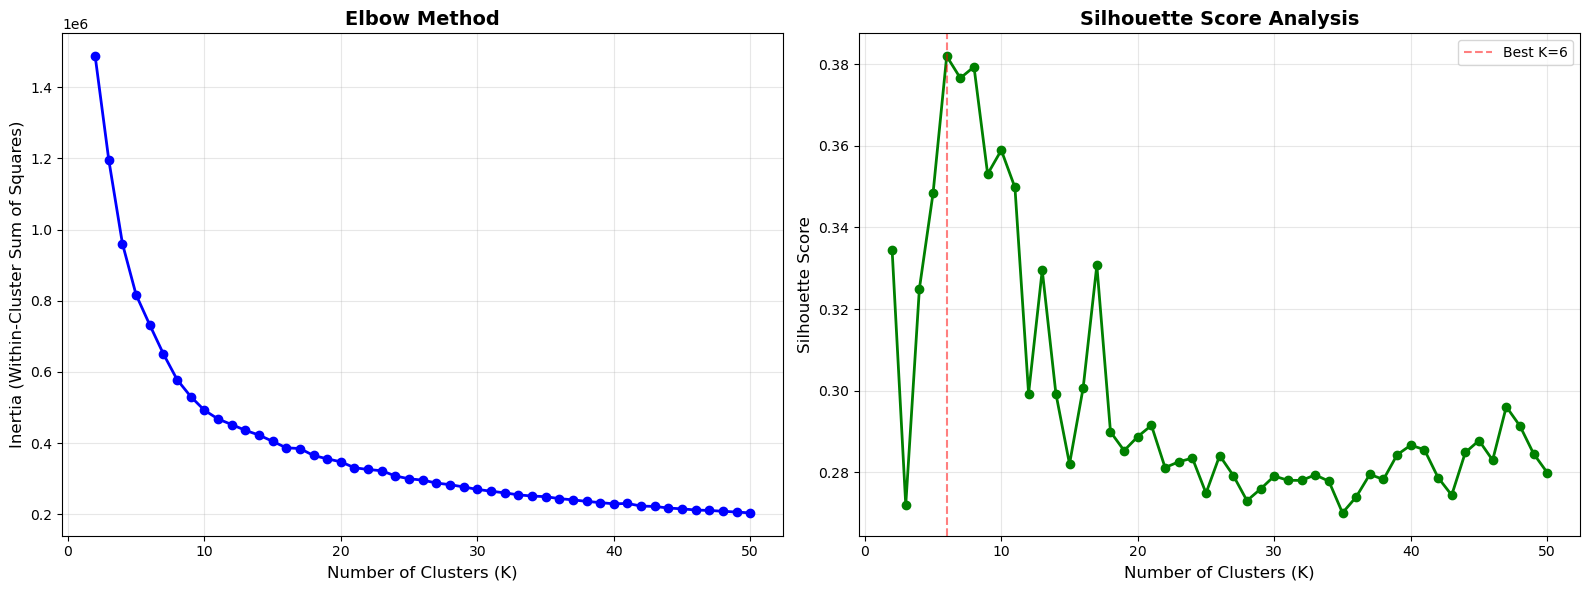


=== Recommendations ===
Best K based on Silhouette Score: 6
Silhouette Score at K=6: 0.3819

Note: Look for the 'elbow' in the left plot where the rate of decrease sharply shifts.


In [7]:
max_k = 50  
k_range = range(2, max_k + 1)

# Storage for metrics
inertias = []
silhouette_scores = []

print(f"Testing K values from 2 to {max_k}...")
for k in k_range:
    # Train KMeans
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_pca)
    
    # Calculate metrics
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels_temp))
    
    if k % 10 == 0:
        print(f"K={k}: Inertia={kmeans_temp.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=6)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mark the best K based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== Recommendations ===")
print(f"Best K based on Silhouette Score: {best_k}")
print(f"Silhouette Score at K={best_k}: {max(silhouette_scores):.4f}")
print(f"\nNote: Look for the 'elbow' in the left plot where the rate of decrease sharply shifts.")

In [8]:
# Define parameter grid
param_grid = {
    'n_clusters': [6], 
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 300, 500],
    'algorithm': ['lloyd', 'elkan']
}

# Custom scorer using silhouette score 
def kmeans_scorer(estimator, X_pca):
    labels = estimator.predict(X_pca)
    return silhouette_score(X_pca, labels)

scorer = make_scorer(kmeans_scorer)

# Create GridSearchCV object
print("Starting Grid Search for K=6...")
grid_search = GridSearchCV(
    estimator=KMeans(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1 
)

# Fit Grid Search
grid_search.fit(X_pca)

print("\n=== Grid Search Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Silhouette Score: {grid_search.best_score_:.4f}")

# Display all results sorted by score
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
print("\n=== Top 10 Configurations ===")
print(results_df.to_string(index=False))

Starting Grid Search for K=6...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\anfel\anaconda3\envs\dm\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



=== Grid Search Results ===
Best Parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 10}
Best Silhouette Score: nan

=== Top 10 Configurations ===
                                                                                     params  mean_test_score  std_test_score  rank_test_score
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 10}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 20}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 30}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 6, 'n_init': 10}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 6, 'n_init': 20}   

In [9]:
# Train final model with best parameters
best_kmeans = grid_search.best_estimator_
best_labels = best_kmeans.labels_


Clustering Metrics
  WCSS (compactness)      : 732159.2411  (minimize)
  Silhouette Score        : 0.3819  (maximize)
  Davies-Bouldin Index    : 0.9910  (minimize)
  Calinski-Harabasz Index : 18606.8122  (maximize)
  Dunn Index              : 0.0116  (maximize)


Clustering Metrics
  WCSS (compactness)      : 732159.2411  (minimize)
  Silhouette Score        : 0.3819  (maximize)
  Davies-Bouldin Index    : 0.9910  (minimize)
  Calinski-Harabasz Index : 18606.8122  (maximize)
  Dunn Index              : 0.0116  (maximize)


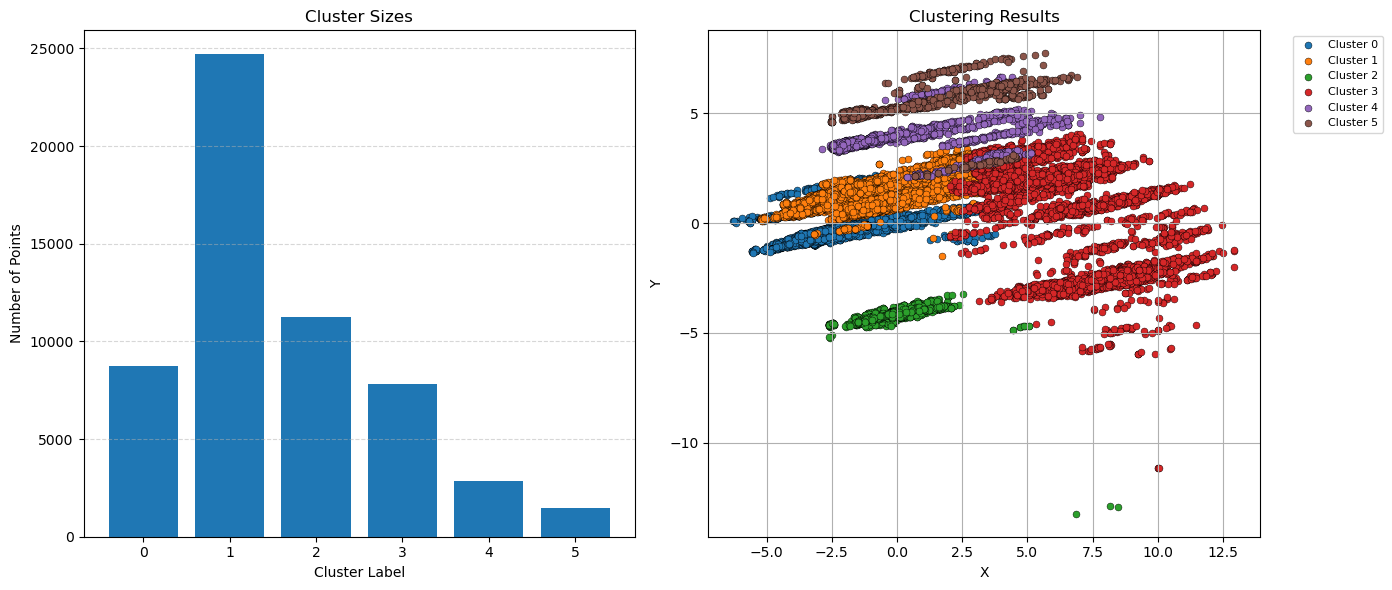

In [14]:
show_clustering_report(X_pca, best_labels)

In [15]:
print("Silhouette Score :", silhouette_score(X_pca, best_labels))
print("Davies-Bouldin Index :", davies_bouldin_score(X_pca, best_labels))
print("Calinski-Harabasz Index :", calinski_harabasz_score(X_pca, best_labels))
print("WCSS :", compute_wcss(X_pca, best_labels))
print("Dunn Index :", compute_dunn_index(X_pca, best_labels))

Silhouette Score : 0.38194582863203047
Davies-Bouldin Index : 0.9910204339805061
Calinski-Harabasz Index : 18606.812212132856
WCSS : 732159.2411133306
Dunn Index : 0.01164999070758492


Clustering Metrics
  WCSS (compactness)      : 1680777.8288  (minimize)
  Silhouette Score        : -0.0276  (maximize)
  Davies-Bouldin Index    : 8.0353  (minimize)
  Calinski-Harabasz Index : 2896.5374  (maximize)
  Dunn Index              : 0.0000  (maximize)


Clustering Metrics
  WCSS (compactness)      : 1680777.8288  (minimize)
  Silhouette Score        : -0.0276  (maximize)
  Davies-Bouldin Index    : 8.0353  (minimize)
  Calinski-Harabasz Index : 2896.5374  (maximize)
  Dunn Index              : 0.0000  (maximize)


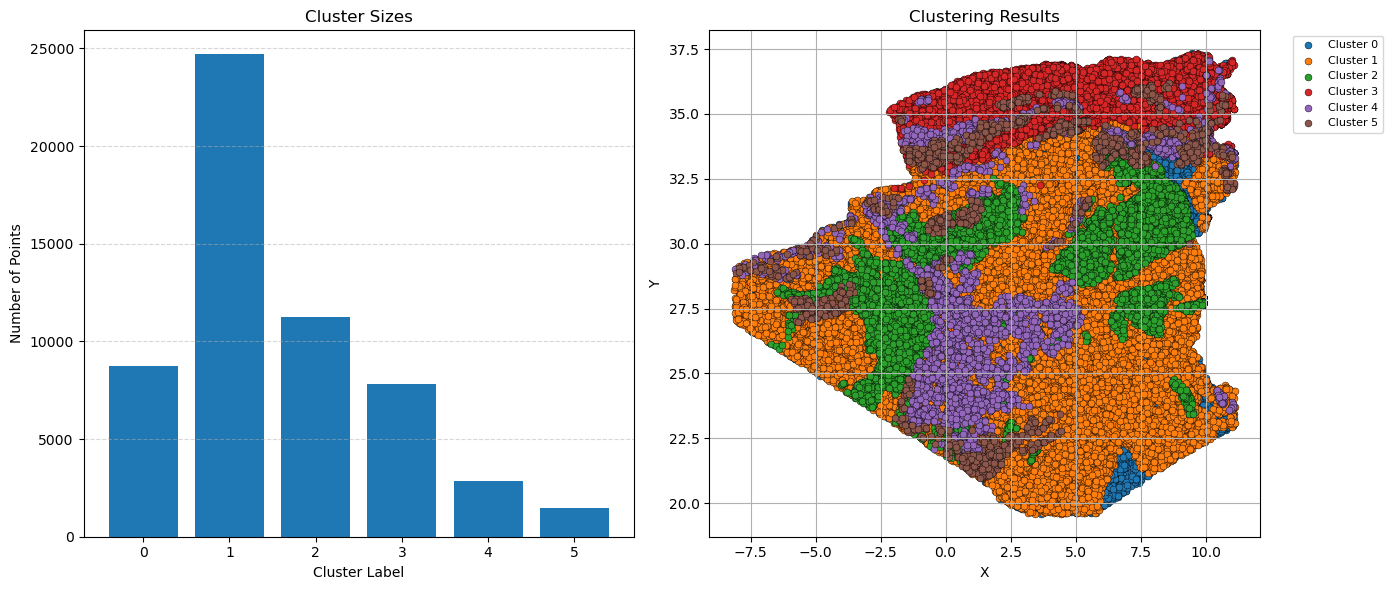

In [ ]:
# Visualisation spatiale avec les coordonnées d'origine
show_clustering_report(lon_lat.to_numpy(), best_labels)

# Scratch Model Training

In [35]:
class FastKMeans:
    def __init__(self, n_clusters=6, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        
    def fit(self, X_pca):
        np.random.seed(self.random_state)
        
        # Initialize centroids randomly
        random_indices = np.random.choice(X_pca.shape[0], self.n_clusters, replace=False)
        self.centroids = X_pca[random_indices]
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroid
            distances = self._compute_distances(X_pca)
            new_labels = np.argmin(distances, axis=1)
            
            # Check convergence
            if iteration > 0 and np.array_equal(new_labels, self.labels_):
                break
                
            self.labels_ = new_labels
            
            # Update centroids
            for k in range(self.n_clusters):
                cluster_points = X_pca[self.labels_ == k]
                if len(cluster_points) > 0:
                    self.centroids[k] = cluster_points.mean(axis=0)
        
        # Calculate inertia (sum of squared distances to centroids)
        self.inertia_ = self._calculate_inertia(X_pca)
        
        return self
    
    def _compute_distances(self, X_pca):
        """
        Vectorized distance computation from all points to all centroids.
        Uses (a - b)^2 = a^2 + b^2 - 2ab trick.
        """
        X_square = np.sum(X_pca**2, axis=1).reshape(-1, 1)
        centroids_square = np.sum(self.centroids**2, axis=1)
        cross = X_pca @ self.centroids.T
        
        distances = X_square + centroids_square - 2 * cross
        return distances
    
    def _calculate_inertia(self, X_pca):
        """Calculate sum of squared distances to nearest centroid"""
        distances = self._compute_distances(X_pca)
        min_distances = np.min(distances, axis=1)
        return np.sum(min_distances)
    
    def predict(self, X_pca):
        """Assign points to nearest centroid"""
        distances = self._compute_distances(X_pca)
        return np.argmin(distances, axis=1)


kmeans_scratch = FastKMeans(n_clusters=6, random_state=42)
kmeans_scratch.fit(X_pca)

print(f"Scratch K-Means - Number of clusters: {kmeans_scratch.n_clusters}")
print(f"Scratch K-Means - Inertia: {kmeans_scratch.inertia_:.2f}")

Scratch K-Means - Number of clusters: 6
Scratch K-Means - Inertia: 780715.56


# Scratch Model Evaluation

Clustering Metrics
  WCSS (compactness)      : 780715.5566  (minimize)
  Silhouette Score        : 0.3360  (maximize)
  Davies-Bouldin Index    : 1.1705  (minimize)
  Calinski-Harabasz Index : 16742.3159  (maximize)
  Dunn Index              : 0.0119  (maximize)


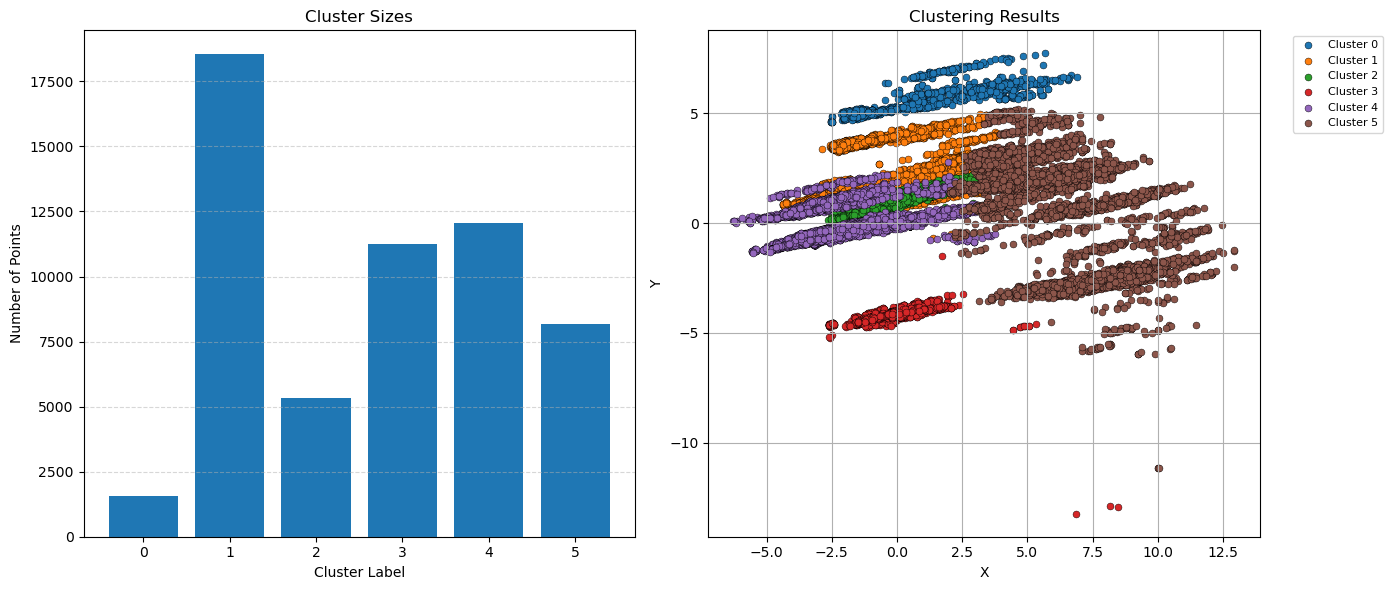

In [ ]:
show_clustering_report(lon_lat.to_numpy(), kmeans_scratch.labels_)

# Comparaison

=== Rapport SKlearn ===
Clustering Metrics
  WCSS (compactness)      : 732159.2411  (minimize)
  Silhouette Score        : 0.3819  (maximize)
  Davies-Bouldin Index    : 0.9910  (minimize)
  Calinski-Harabasz Index : 18606.8122  (maximize)
  Dunn Index              : 0.0116  (maximize)


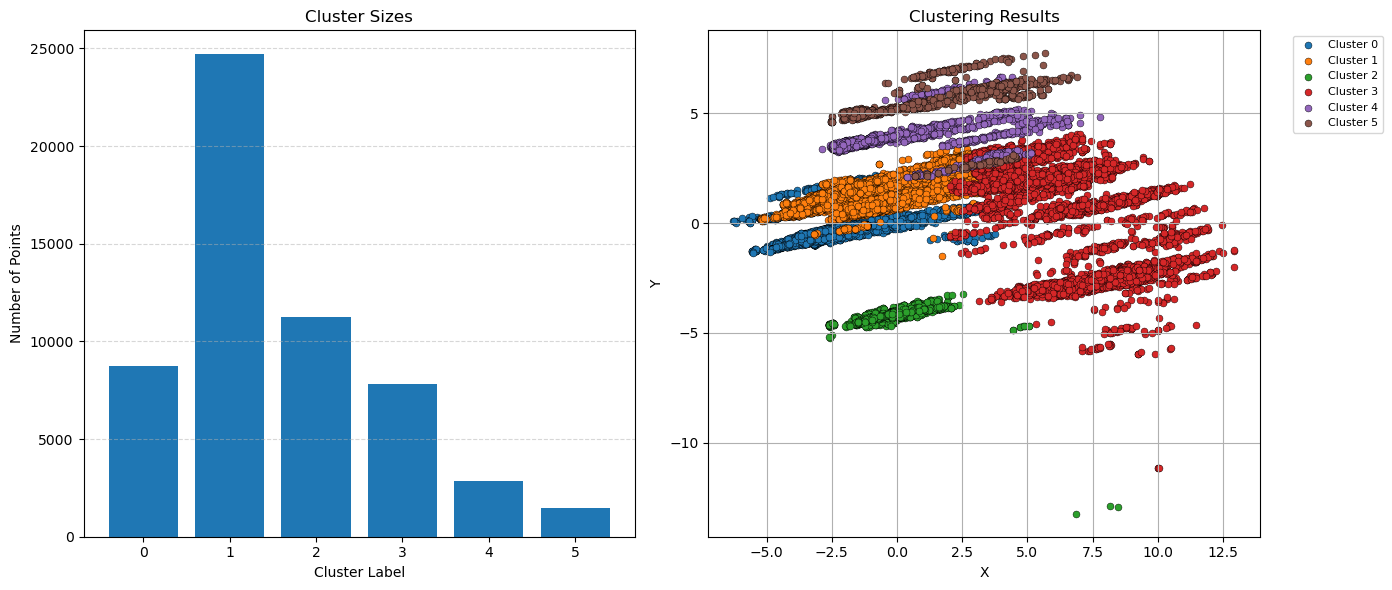


=== Rapport Scratch ===
Clustering Metrics
  WCSS (compactness)      : 780715.5566  (minimize)
  Silhouette Score        : 0.3360  (maximize)
  Davies-Bouldin Index    : 1.1705  (minimize)
  Calinski-Harabasz Index : 16742.3159  (maximize)
  Dunn Index              : 0.0119  (maximize)


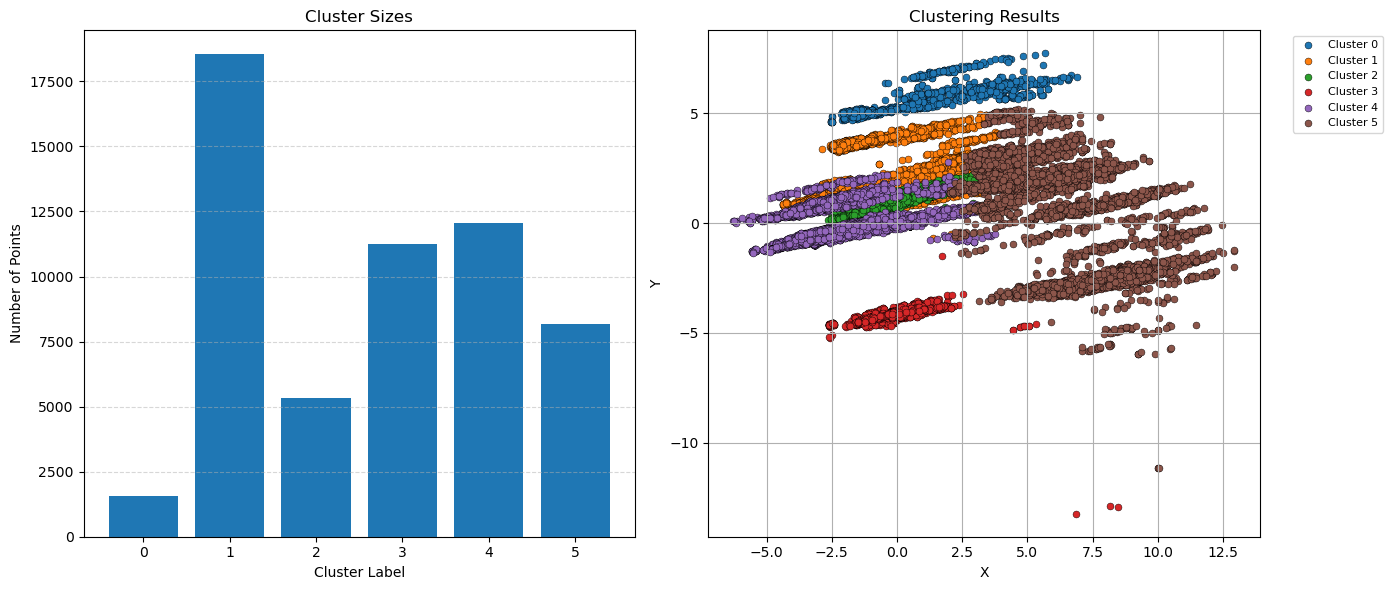


=== Tableau comparatif ===
                    Metric  SKlearn (Grid Search)        Scratch
0         Silhouette Score               0.381946       0.336018
1     Davies-Bouldin Index               0.991020       1.170500
2  Calinski-Harabasz Index           18606.812212   16742.315945
3                     WCSS          732159.241113  780715.556604
4               Dunn Index               0.011650       0.011877
5                  Inertia          732159.357477  780715.556604


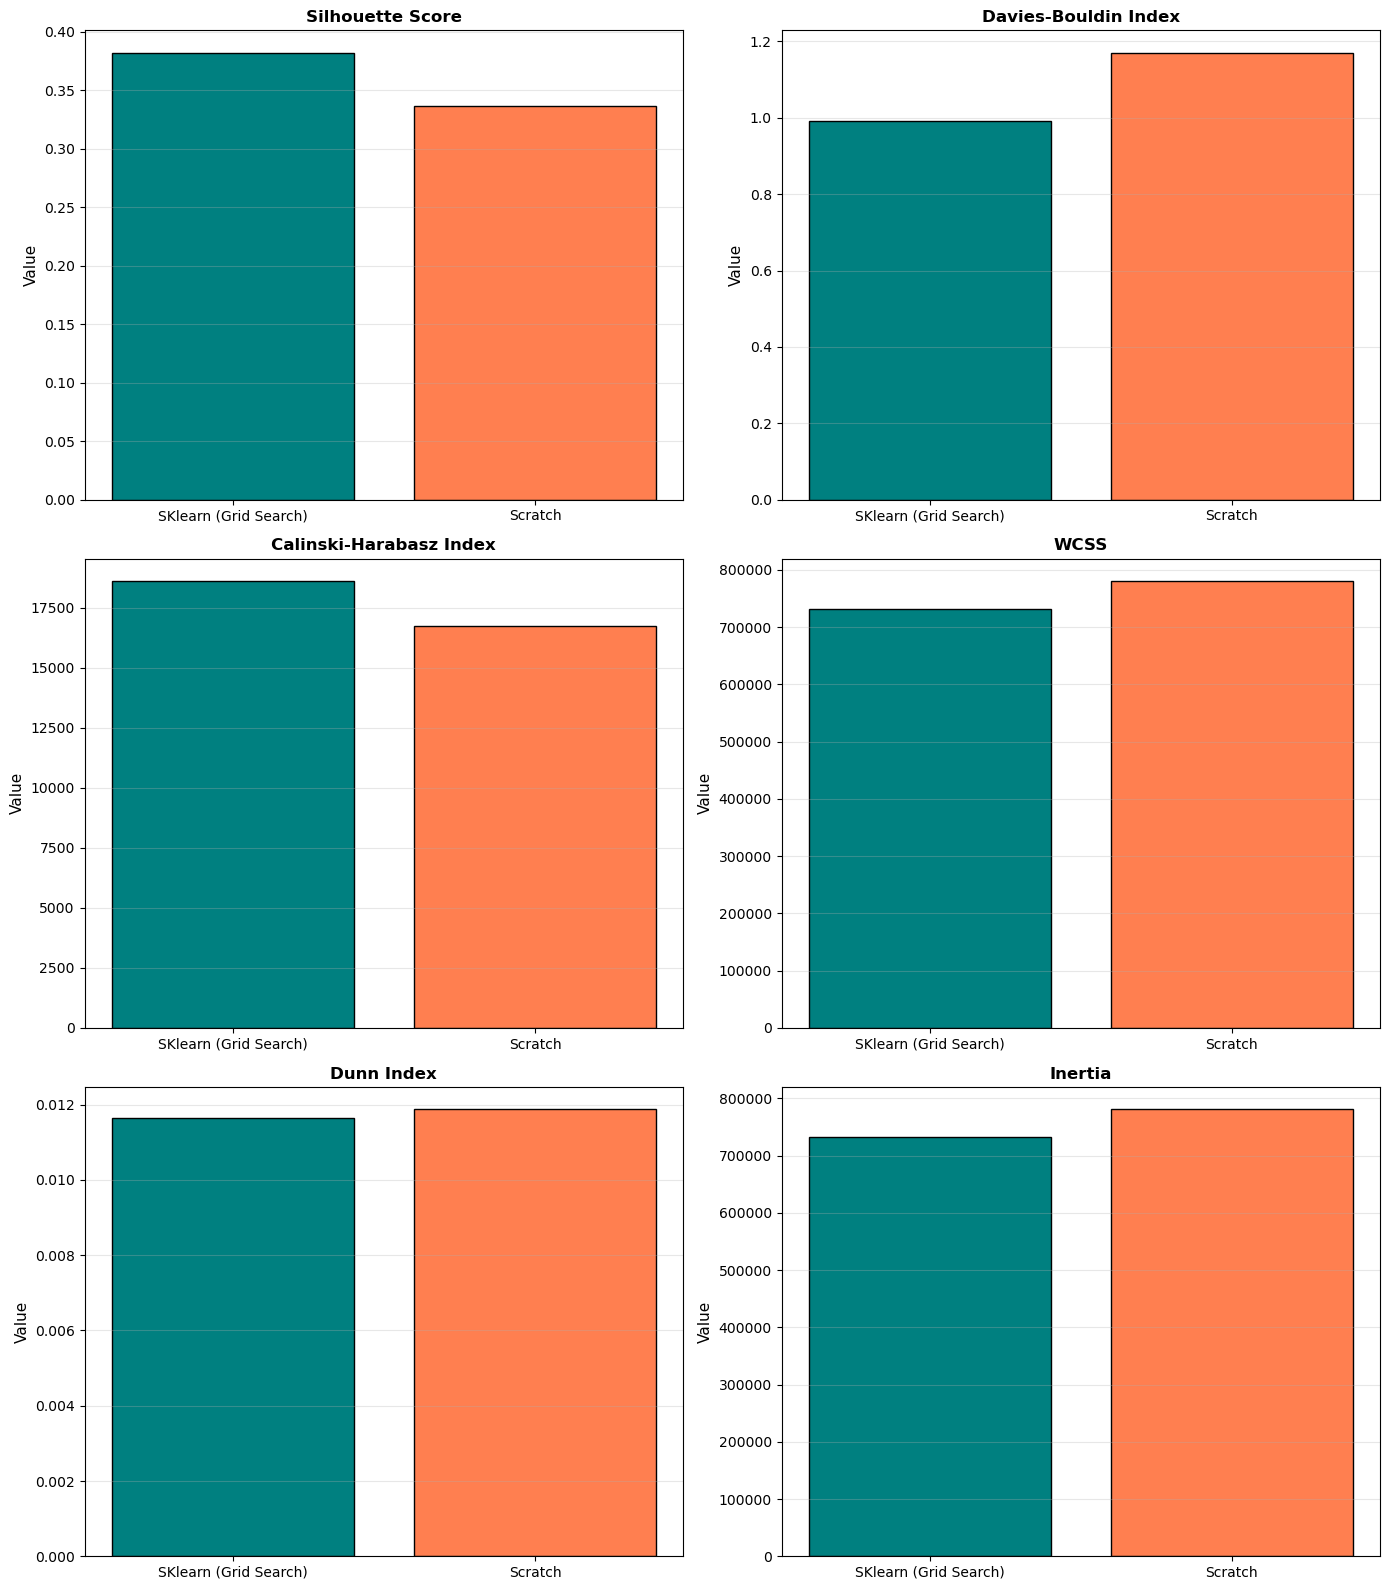

In [ ]:
# Calcul des métriques pour le tableau comparatif
silhouette_best = silhouette_score(X_pca, best_labels)
davies_bouldin_best = davies_bouldin_score(X_pca, best_labels)
calinski_harabasz_best = calinski_harabasz_score(X_pca, best_labels)
wcss_best = compute_wcss(X_pca, best_labels)
dunn_best = compute_dunn_index(X_pca, best_labels)

silhouette_scratch = silhouette_score(X_pca, kmeans_scratch.labels_)
davies_bouldin_scratch = davies_bouldin_score(X_pca, kmeans_scratch.labels_)
calinski_harabasz_scratch = calinski_harabasz_score(X_pca, kmeans_scratch.labels_)
wcss_scratch = compute_wcss(X_pca, kmeans_scratch.labels_)
dunn_scratch = compute_dunn_index(X_pca, kmeans_scratch.labels_)

comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'WCSS', 'Dunn Index', 'Inertia'],
    'SKlearn (Grid Search)': [silhouette_best, davies_bouldin_best, calinski_harabasz_best, wcss_best, dunn_best, best_kmeans.inertia_],
    'Scratch': [silhouette_scratch, davies_bouldin_scratch, calinski_harabasz_scratch, wcss_scratch, dunn_scratch, kmeans_scratch.inertia_]
})

print("\n=== Tableau comparatif ===")
print(comparison_df)

# Visualisation des comparaisons
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'WCSS', 'Dunn Index', 'Inertia']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    row = comparison_df[comparison_df['Metric'] == metric]
    ax.bar(['SKlearn (Grid Search)', 'Scratch'], [row['SKlearn (Grid Search)'].values[0], row['Scratch'].values[0]], 
           color=['teal', 'coral'], edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()